In [94]:
import pickle
import pandas as pd
import numpy as np
from ClassifierWrapper import *
from Vectorizer import *
from sklearn.model_selection import train_test_split
from sklearn import metrics
from TextClassifier import TextClassifier
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline 

In [95]:
model_set = {
    "ensemble_fasttext_cnn_cntvecnb_lr": {
        "vec": [VectorizerCountVecNB(),
                VectorizerEmbedding(docLen=5000,word_vector_file="../wordvecs/wiki-news-300d-1M.vec")],
        "clf": [LogisticRegressionWrapper(C=4, dual=True),
                CNNWrapper(docLen=5000)]
    },
    "fasttext_cnn": {
        "vec": [VectorizerCountVec()],
        "clf": [LogisticRegressionWrapper(C=4, dual=True)]
    },
    "glove_cnn": {
        "vec": [VectorizerEmbedding(docLen=5000,word_vector_file="../wordvecs/glove.6B.50d.txt")],
        "clf": [CNNWrapper(docLen=5000)]
    },
    "lr_cntvec": {
        "vec": [VectorizerCountVec()],
        "clf": [LogisticRegressionWrapper(C=4, dual=True)]
    },
    "lr_cntvecnb": {
        "vec": [VectorizerCountVecNB()],
        "clf": [LogisticRegressionWrapper(C=4, dual=True)]
    },
    "lr_tfidf": {
        "vec": [VectorizerTFIDF()],
        "clf": [LogisticRegressionWrapper(C=4, dual=True)]
    },
    "lr_tfidfnb": {
        "vec": [VectorizerTFIDFNB()],
        "clf": [LogisticRegressionWrapper(C=4, dual=True)]
    },
    "mnb_cntvec": {
        "vec": [VectorizerCountVec()],
        "clf": [MultinomialNBWrapper()]
    },
    "rf_cntvec": {
        "vec": [VectorizerCountVec()],
        "clf": [RandomForestClassifierWrapper(n_estimators=50,
                                              max_features=0.8,
                                              random_state=42,n_jobs=-1)]
    },
    "rf_cntvecnb": {
        "vec": [VectorizerCountVecNB()],
        "clf": [RandomForestClassifierWrapper(n_estimators=50,
                                              max_features=0.8,
                                              random_state=42,n_jobs=-1)]
    },
    "rf_tfidf": {
        "vec": [VectorizerTFIDF()],
        "clf": [RandomForestClassifierWrapper(n_estimators=50,
                                              max_features=0.8,
                                              random_state=42,n_jobs=-1)]
    },
    "rf_tfidfnb": {
        "vec": [VectorizerTFIDFNB()],
        "clf": [RandomForestClassifierWrapper(n_estimators=50,
                                              max_features=0.8,
                                              random_state=42,n_jobs=-1)]
    },
    "svmlinear_tfidf": {
        "vec": [VectorizerTFIDF()],
        "clf": [SVCWrapper(kernel='linear',probability=True)]
    },
    "svmlinear_tfidfnb": {
        "vec": [VectorizerTFIDFNB()],
        "clf": [SVCWrapper(kernel='linear',probability=True)]
    },
    "svmlinear_cntvec": {
        "vec": [VectorizerCountVec()],
        "clf": [SVCWrapper(kernel='linear',probability=True)]
    },
    "svmlinear_cntvecnb": {
        "vec": [VectorizerCountVecNB()],
        "clf": [SVCWrapper(kernel='linear',probability=True)]
    },
    "lrbagging_tfidf": {
        "vec": [VectorizerTFIDF()],
        "clf": [BaggingClassifierWrapper(base_estimator=LogisticRegression(),
                                         n_estimators=50,
                                         bootstrap=True,
                                         bootstrap_features=True,
                                         verbose=1,
                                         n_jobs=-1)]
    },
    "lrbagging_tfidfnb": {
        "vec": [VectorizerTFIDFNB()],
        "clf": [BaggingClassifierWrapper(base_estimator=LogisticRegression(),
                                         n_estimators=50,
                                         bootstrap=True,
                                         bootstrap_features=True,
                                         verbose=1,
                                         n_jobs=-1)]
    },
    "lrbagging_cntvec": {
        "vec": [VectorizerCountVec()],
        "clf": [BaggingClassifierWrapper(base_estimator=LogisticRegression(),
                                         n_estimators=50,
                                         bootstrap=True,
                                         bootstrap_features=True,
                                         verbose=1,
                                         n_jobs=-1)]
    },
    "lrbagging_cntvecnb": {
        "vec": [VectorizerCountVecNB()],
        "clf": [BaggingClassifierWrapper(base_estimator=LogisticRegression(),
                                         n_estimators=50,
                                         bootstrap=True,
                                         bootstrap_features=True,
                                         verbose=1,
                                         n_jobs=-1)]
    }
}


In [96]:
# Read data
np.random.seed(0)
df = pd.read_csv("../data/normalized_texts_labels.csv",encoding="utf-8")
df = df[["normalized_title","normalized_text","fake"]]
df.columns = ["titles","texts","labels"]
print("# of NaN of texts:" + str(df["texts"].isnull().sum()))
print("# of NaN of labels:" + str(df["labels"].isnull().sum()))
print("# of NaN of titles:" + str(df["titles"].isnull().sum()))
df = df.dropna()
y = df["labels"].values
X = df["texts"].values
X, X_test, y, y_test = train_test_split(X, y, stratify=y, random_state=12345, test_size=0.2, shuffle=True)

# of NaN of texts:109
# of NaN of labels:0
# of NaN of titles:7


In [97]:
cv_scores_summary = pd.DataFrame(columns=["model_name","metric_name","mean","std"])
for k,v in model_set.items():
    model_name = k
    saved_folder = "../saved_models/" + model_name
    cv_score_file_name = saved_folder + "/" + "cv_score.pickle"
    cv_scores = pickle.load( open( cv_score_file_name, "rb" ) )
    cv_scores = cv_scores[["mean","std"]]
    cv_scores.index.name = ""
    cv_scores.columns.name = ""
    cv_scores = cv_scores[cv_scores.index.str.contains("val")]
    for index, row in cv_scores.iterrows():
        #print(index,row)
        cv_scores_summary = cv_scores_summary.append({'model_name' : model_name,
                                  'metric_name' : index,
                                  "mean": row["mean"],
                                  "std": row["std"]
                                  } , ignore_index=True)

In [103]:
acc_df = cv_scores_summary[cv_scores_summary["metric_name"].str.contains("acc")]
acc_df = acc_df.sort_values("mean",ascending=False)
auc_df = cv_scores_summary[cv_scores_summary["metric_name"].str.contains("auc")]
auc_df = auc_df.sort_values("mean",ascending=False)


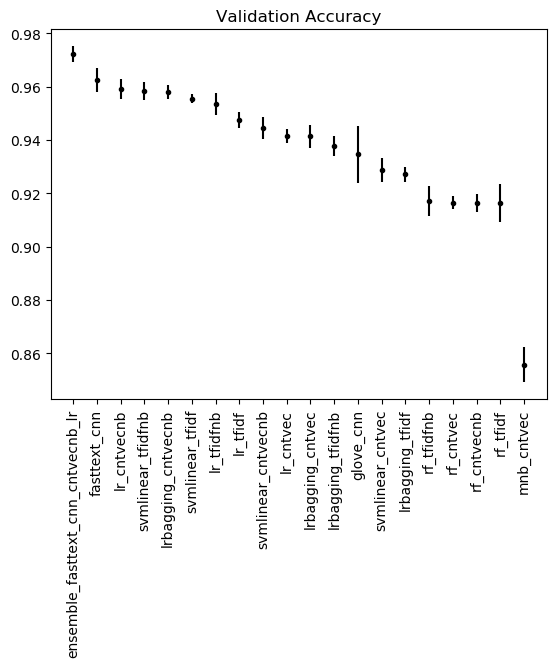

In [104]:
plt.rcdefaults()
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.errorbar(np.arange(len(acc_df["mean"])), list(acc_df["mean"]), 
             yerr=list(acc_df["std"]), fmt='.k')
ax.set_xticks(np.arange(len(acc_df["mean"])))
ax.set_xticklabels(acc_df["model_name"],rotation='vertical')
ax.set_title("Validation Accuracy")
plt.show()

In [63]:
model_name = "ensemble_fasttext_cnn_cntvecnb_lr"
saved_folder = "../saved_models/" + model_name
tc = TextClassifier(vectorizerList=model_set[model_name]["vec"],
                    classifierList=model_set[model_name]["clf"])
tc.load_models(saved_folder)
pred_test = tc.predict(X_test)
print(metrics.f1_score(y_test, pred_test>0.5))

loading models and vectorizer from ../saved_models/ensemble_fasttext_cnn_cntvecnb_lr
loading model from ../saved_models/ensemble_fasttext_cnn_cntvecnb_lr/0.model
loading vectorizer from ../saved_models/ensemble_fasttext_cnn_cntvecnb_lr/0.vec
loading model from ../saved_models/ensemble_fasttext_cnn_cntvecnb_lr/1.model
loading vectorizer from ../saved_models/ensemble_fasttext_cnn_cntvecnb_lr/1.vec
0.9665965895818733


In [61]:
print(metrics.f1_score(y, pred>0.5))

0.9999419987239719
